In [2]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from dotenv import load_dotenv

c:\Users\Abhishek\Desktop\langgraph_learning\langgraph_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()

True

In [4]:
generator_llm = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")
evaluator_llm = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")
optimizer_llm = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")

In [5]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [6]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [7]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [8]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [9]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [10]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [11]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

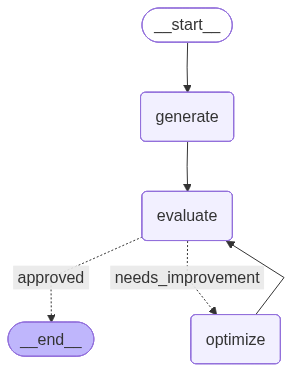

In [12]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow



In [13]:
initial_state = {
    "topic": "Attention is all you need",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [14]:
result

{'topic': 'Attention is all you need',
 'tweet': 'Turns out "Attention is all you need" is less about enlightenment and more about me posting blurry pictures of my food until someone likes it. My ancestors are so proud.',
 'evaluation': 'approved',
 'feedback': 'This tweet demonstrates strong originality by cleverly twisting the well-known phrase "Attention is all you need" into a relatable commentary on social media validation, particularly for those familiar with the original context. The humor lands effectively through self-deprecation and the relatable absurdity of seeking likes for blurry food photos, genuinely eliciting a chuckle. It\'s punchy enough to grab attention in a feed and has high virality potential due to its widespread relatability and niche appeal to a tech-savvy audience. The format is impeccable, adhering to character limits and avoiding common pitfalls like Q&A or setup-punchline structures, while the ending line enhances the humor rather than deflating it.',
 'it

In [15]:
for tweet in result['tweet_history']:
    print(tweet)

Turns out "Attention is all you need" is less about enlightenment and more about me posting blurry pictures of my food until someone likes it. My ancestors are so proud.
